<a href="https://colab.research.google.com/github/SahputraS/Outbreak-Simulation-and-Detection-Testing/blob/main/Endemic_Label_SP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Download the packages if not already available
packages_needed <- c("mem", "ggTimeSeries", "fuzzyjoin", "zoo", "yardstick", "purrr", "plotly")
packages_to_install <- packages_needed[!(packages_needed %in% installed.packages()[,"Package"])]

if(length(packages_to_install)) {
  install.packages(packages_to_install)
}
lapply(packages_needed, library, character.only = TRUE)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘nortest’, ‘sp’, ‘sparsevctrs’, ‘sm’, ‘mclust’, ‘RcppRoll’, ‘EnvStats’, ‘stringdist’, ‘geosphere’, ‘hardhat’, ‘lazyeval’, ‘crosstalk’


Loading required package: ggplot2


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:stats’:

    filter


The following object is masked from ‘package:graphics’:

    layout




[[1]]
[1] "mem"       "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[2]]
 [1] "ggTimeSeries" "ggplot2"      "mem"          "stats"        "graphics"    
 [6] "grDevices"    "utils"        "datasets"     "methods"      "base"        

[[3]]
 [1] "fuzzyjoin"    "ggTimeSeries" "ggplot2"      "mem"          "stats"       
 [6] "graphics"     "grDevices"    "utils"        "datasets"     "methods"     
[11] "base"        

[[4]]
 [1] "zoo"          "fuzzyjoin"    "ggTimeSeries" "ggplot2"      "mem"         
 [6] "stats"        "graphics"     "grDevices"    "utils"        "datasets"    
[11] "methods"      "base"        

[[5]]
 [1] "yardstick"    "zoo"          "fuzzyjoin"    "ggTimeSeries" "ggplot2"     
 [6] "mem"          "stats"        "graphics"     "grDevices"    "utils"       
[11] "datasets"     "methods"      "base"        

[[6]]
 [1] "purrr"        "yardstick"    "zoo"          "fuzzyjoin"    "ggTimeSeries"
 [6] "ggplot2"      "mem"          "stats"        "graphics"     "grDevices"   
[11] "utils"        "datasets"     "methods"      "base"        

[[7]]
 [1] "plotly"       "purrr"        "yardstick"    "zoo"          "fuzzyjoin"   
 [6] "ggTimeSeries" "ggplot2"      "mem"          "stats"        "graphics"    
[11] "grDevices"    "utils"        "datasets"     "methods"      "base"

In [2]:
library(readxl)
library(stringi)

library(dplyr)
library(ggplot2)
library(tidyr)
library(tibble)

library(lubridate)

library(ggTimeSeries)
library(readr)
library(fuzzyjoin)

library(mem)
library(zoo)
library(yardstick)

library(purrr)
library(plotly)
library(htmlwidgets)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘readr’


The following object is masked from ‘package:yardstick’:

    spec




## Upload Infodengue data

In [3]:
library(googledrive)
library(googlesheets4)


Attaching package: ‘googlesheets4’


The following objects are masked from ‘package:googledrive’:

    request_generate, request_make




In [4]:
# Save cache in a file so that i don't have to authenticate repeatedly
drive_auth(cache = "/content/drive/My Drive/.secrets", use_oob = TRUE)

Please point your browser to the following url: 

https://accounts.google.com/o/oauth2/v2/auth?client_id=603366585132-frjlouoa3s2ono25d2l9ukvhlsrlnr7k.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&redirect_uri=https%3A%2F%2Fwww.tidyverse.org%2Fgoogle-callback%2F&response_type=code&state=1cf3cb65465fd87c52e3765533222118&access_type=offline&prompt=consent



Enter authorization code: eyJjb2RlIjoiNC8wQWZySWVwQTQ2Szd0Sm9OLVZSRmJiODJYd3VEcl83bENKYkxRMVJIYWRzT2k5TVcyX2Z3TG16d1BsOE1WUDVoam5MekpOUSIsInN0YXRlIjoiMWNmM2NiNjU0NjVmZDg3YzUyZTM3NjU1MzMyMjIxMTgifQ==


## Donwload InfoDengue on Target Municipalities

In [ ]:
# drv_file <- drive_get("GISAID/data_sp_incidence_target.csv")  # a Drive *file*, not a local path
# drive_download(file = drv_file, path = "data_sp_incidence_target.csv", overwrite = TRUE)

# data <- read_csv("data_sp_incidence_target.csv")

In [5]:
get_alert_periods <- function(df) {
  df <- df %>%
    arrange(data_iniSE) %>%
    mutate(change = (nivel != lag(nivel, default = first(nivel))),
           group = cumsum(change))

  df %>%
    group_by(group, nivel) %>%
    summarise(start = min(data_iniSE),
              end = max(data_iniSE),
              .groups = "drop")
}

In [6]:
download_data <- function(geocode,
                              ew_start = 1, ew_end = 52,
                              ey_start = 2010, ey_end = 2025){
  url <- "https://info.dengue.mat.br/api/alertcity?"
  cons <- paste0(url,
                 "geocode=", geocode,
                 "&disease=dengue",
                 "&format=csv",
                 "&ew_start=", ew_start,
                 "&ew_end=", ew_end,
                 "&ey_start=", ey_start,
                 "&ey_end=", ey_end)

  dados <- read_csv(cons, show_col_types = FALSE) %>% arrange(data_iniSE)
  dados$ibge <- geocode
  dados$rate_pop <- dados$casos / dados$pop * 100000

  return (dados)}

In [7]:
plot_data <- function(dados, city_name, to_plot) {

  alert_df <- get_alert_periods(dados)

  nivel_colors <- c(
    "1" = "#a8ddb5",
    "2" = "#fdd49e",
    "3" = "#fdae61",
    "4" = "#ef6548"
  )

  options(repr.plot.width = 20, repr.plot.height = 8)
  p <- ggplot() +
    geom_col(data = dados %>% filter(nivel %in% c(1, 2, 3, 4)),
            aes(x = data_iniSE, y = .data[[to_plot]], fill = factor(nivel)),
            width = 7, alpha = 1) +
    geom_line(data = dados, aes(x = data_iniSE, y = .data[[to_plot]]),
              color = "black", size = 1) +
    scale_fill_manual(values = nivel_colors, name = "Alert Level") +
    labs(
      title = paste("Approximated Dengue Cases —", city_name),
      x = "Year",
      y = "Number of Cases per 100K pop"
    ) +
    scale_x_date(date_breaks = "1 year", date_labels = "%Y") +
    theme_light() +
    theme(
      plot.title = element_text(size = 20, face = "bold", hjust = 0),
      axis.text.x = element_text(angle = 0, hjust = 0.5, size = 20),
      axis.text.y = element_text(size = 20),
      axis.title = element_text(size = 20),
      legend.position = "right",
      legend.text = element_text(size = 20),
      legend.title = element_text(size = 20)
    )

  return(p)
}

In [8]:
drv_file <- drive_get("GISAID/sp_gisaid_geocode.csv")
drive_download(file = drv_file, path = "sp_gisaid_geocode.csv", overwrite = TRUE)

target_geocode <- read_csv("sp_gisaid_geocode.csv", show_col_types = FALSE)
codes <- target_geocode %>% pull(1) %>% as.integer()

✔ The input `path` resolved to exactly 1 file.

File downloaded:

• sp_gisaid_geocode.csv <id: 1qzaUKNNeTnuHf3OS3TVitiKEo0RxpO_0>

Saved locally as:

• sp_gisaid_geocode.csv



In [9]:
length(codes)

[1] 186

In [10]:
dd <- vector("list", length(codes))
for (i in seq_along(codes)) {
  ib <- as.integer(codes[i])
  dd[[i]] <- download_data(ib) %>%
    select(data_iniSE, casos, pop, nivel, ibge, rate_pop)
}
sp_data <- bind_rows(dd)

In [ ]:
head(sp_data,3)

data_iniSE,casos,pop,nivel,ibge,rate_pop
<date>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
2010-01-03,9,407252,1,3538709,2.2099339
2010-01-10,4,407252,1,3538709,0.9821928
2010-01-17,5,407252,2,3538709,1.2277411


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


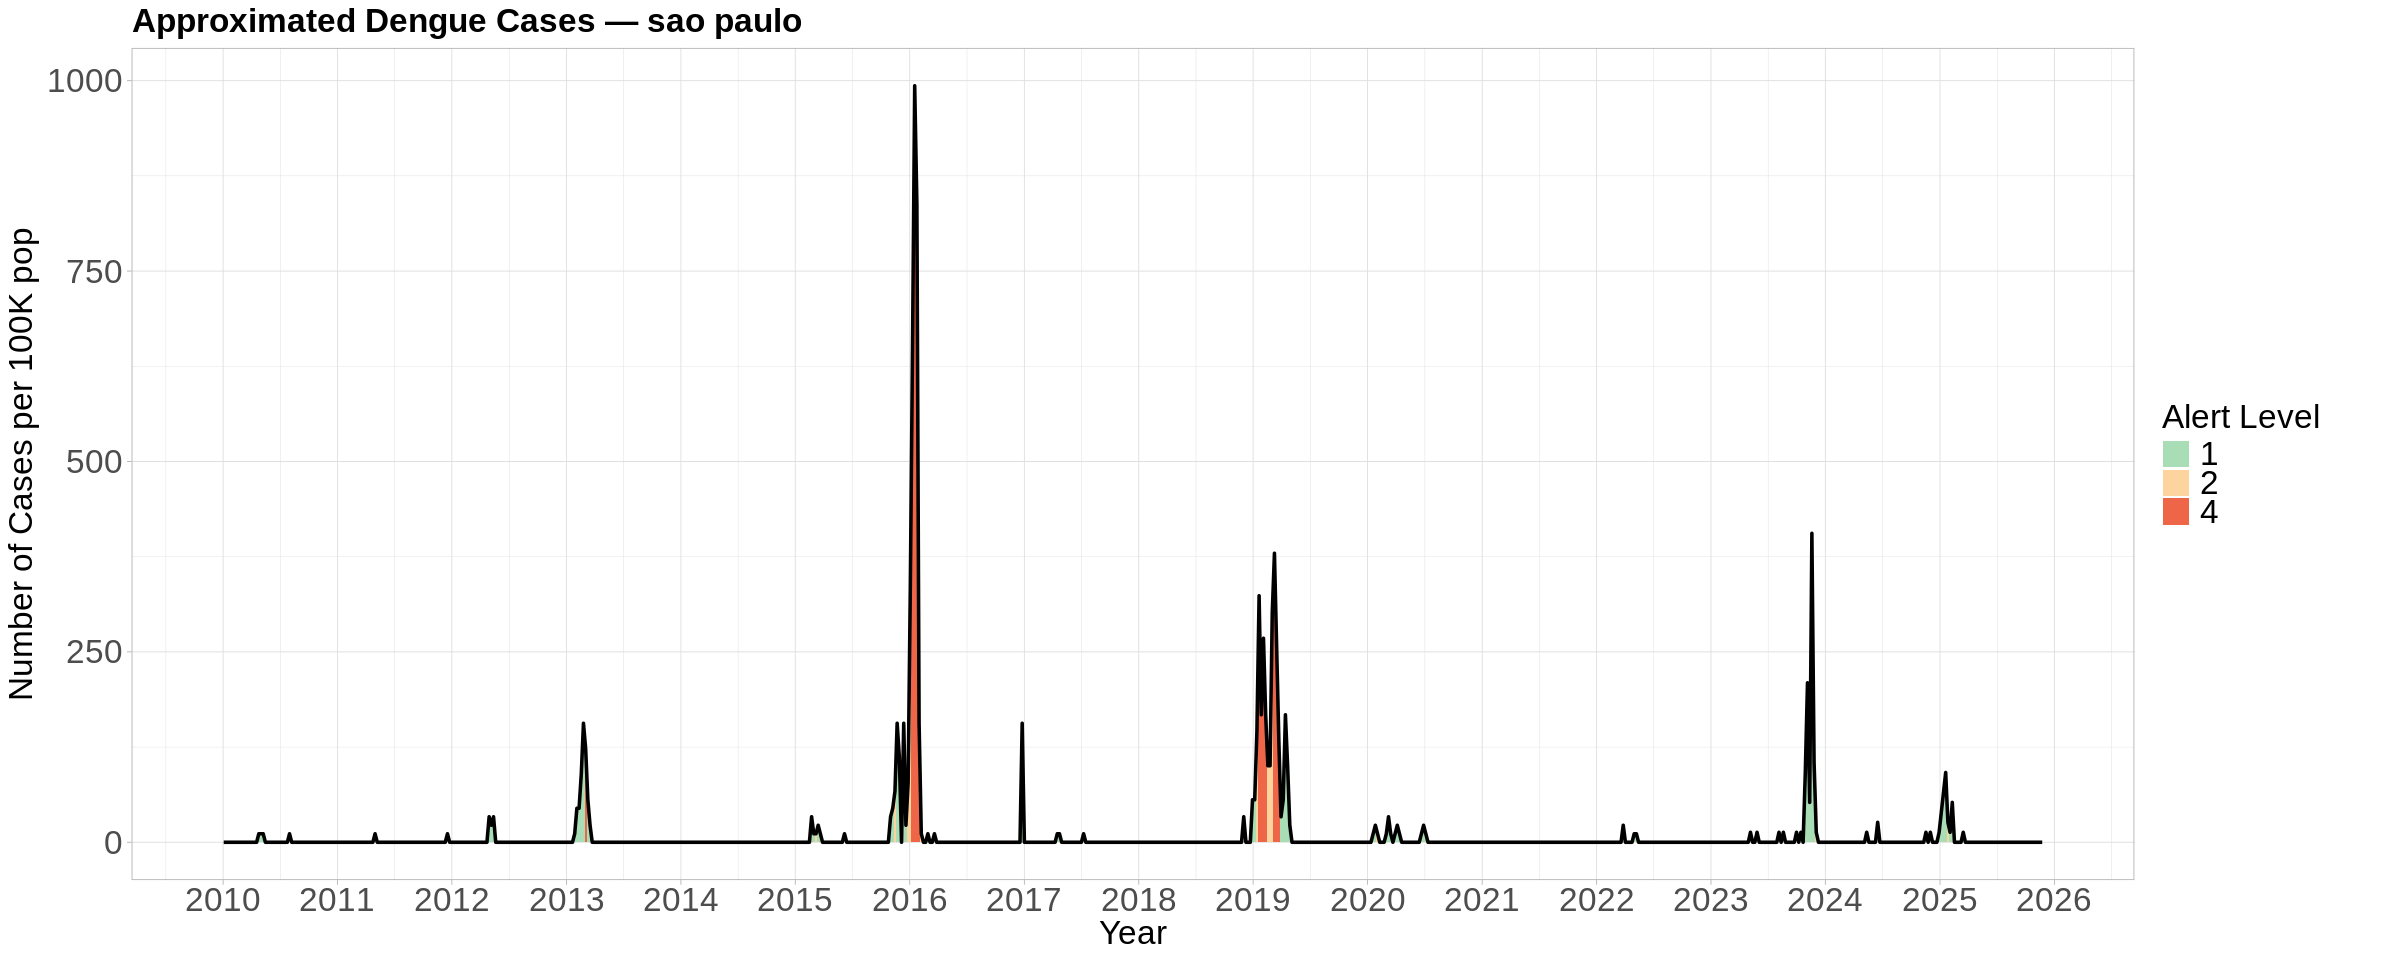

In [ ]:
#Sample
plot_data(sp_data %>% filter(ibge == 3549508), 'sao paulo', 'rate_pop')

In [ ]:
# Check if the data is complete
full_dates <- tibble(
              data_iniSE = seq(floor_date(min(sp_data$data_iniSE), "week", week_start = 7),
              floor_date(max(sp_data$data_iniSE), "week", week_start = 7),
              by = "1 week"))

missing_weeks <- anti_join(full_dates, sp_data, by = "data_iniSE")
missing_weeks

data_iniSE
<date>
2018-04-08


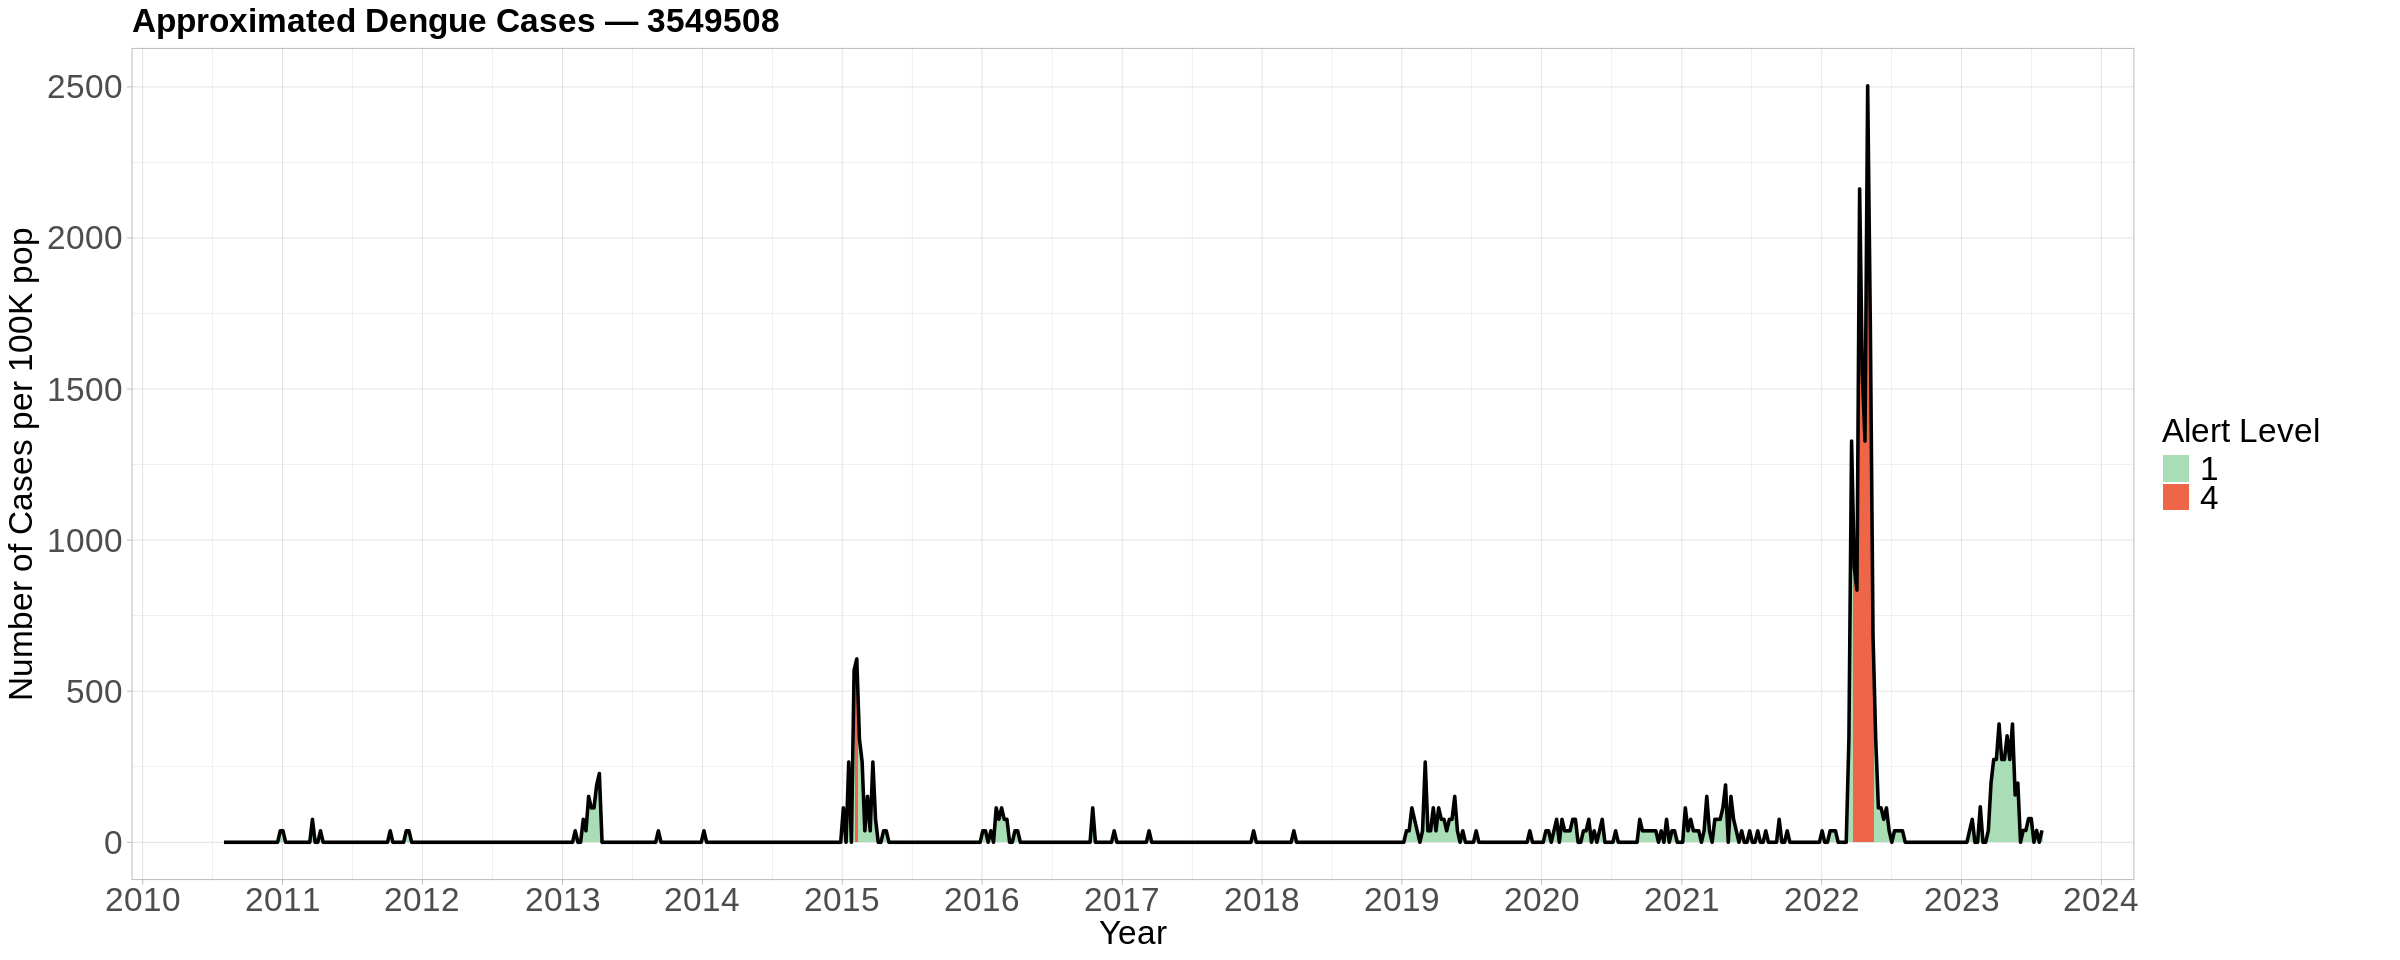

In [ ]:
sp_city_data1 <- sp_data %>% filter(ibge == 3527900) %>% filter(data_iniSE <= as.Date('2023-08-01') & data_iniSE >= as.Date('2010-08-01'))
plot_data(sp_city_data1, '3549508', 'rate_pop')

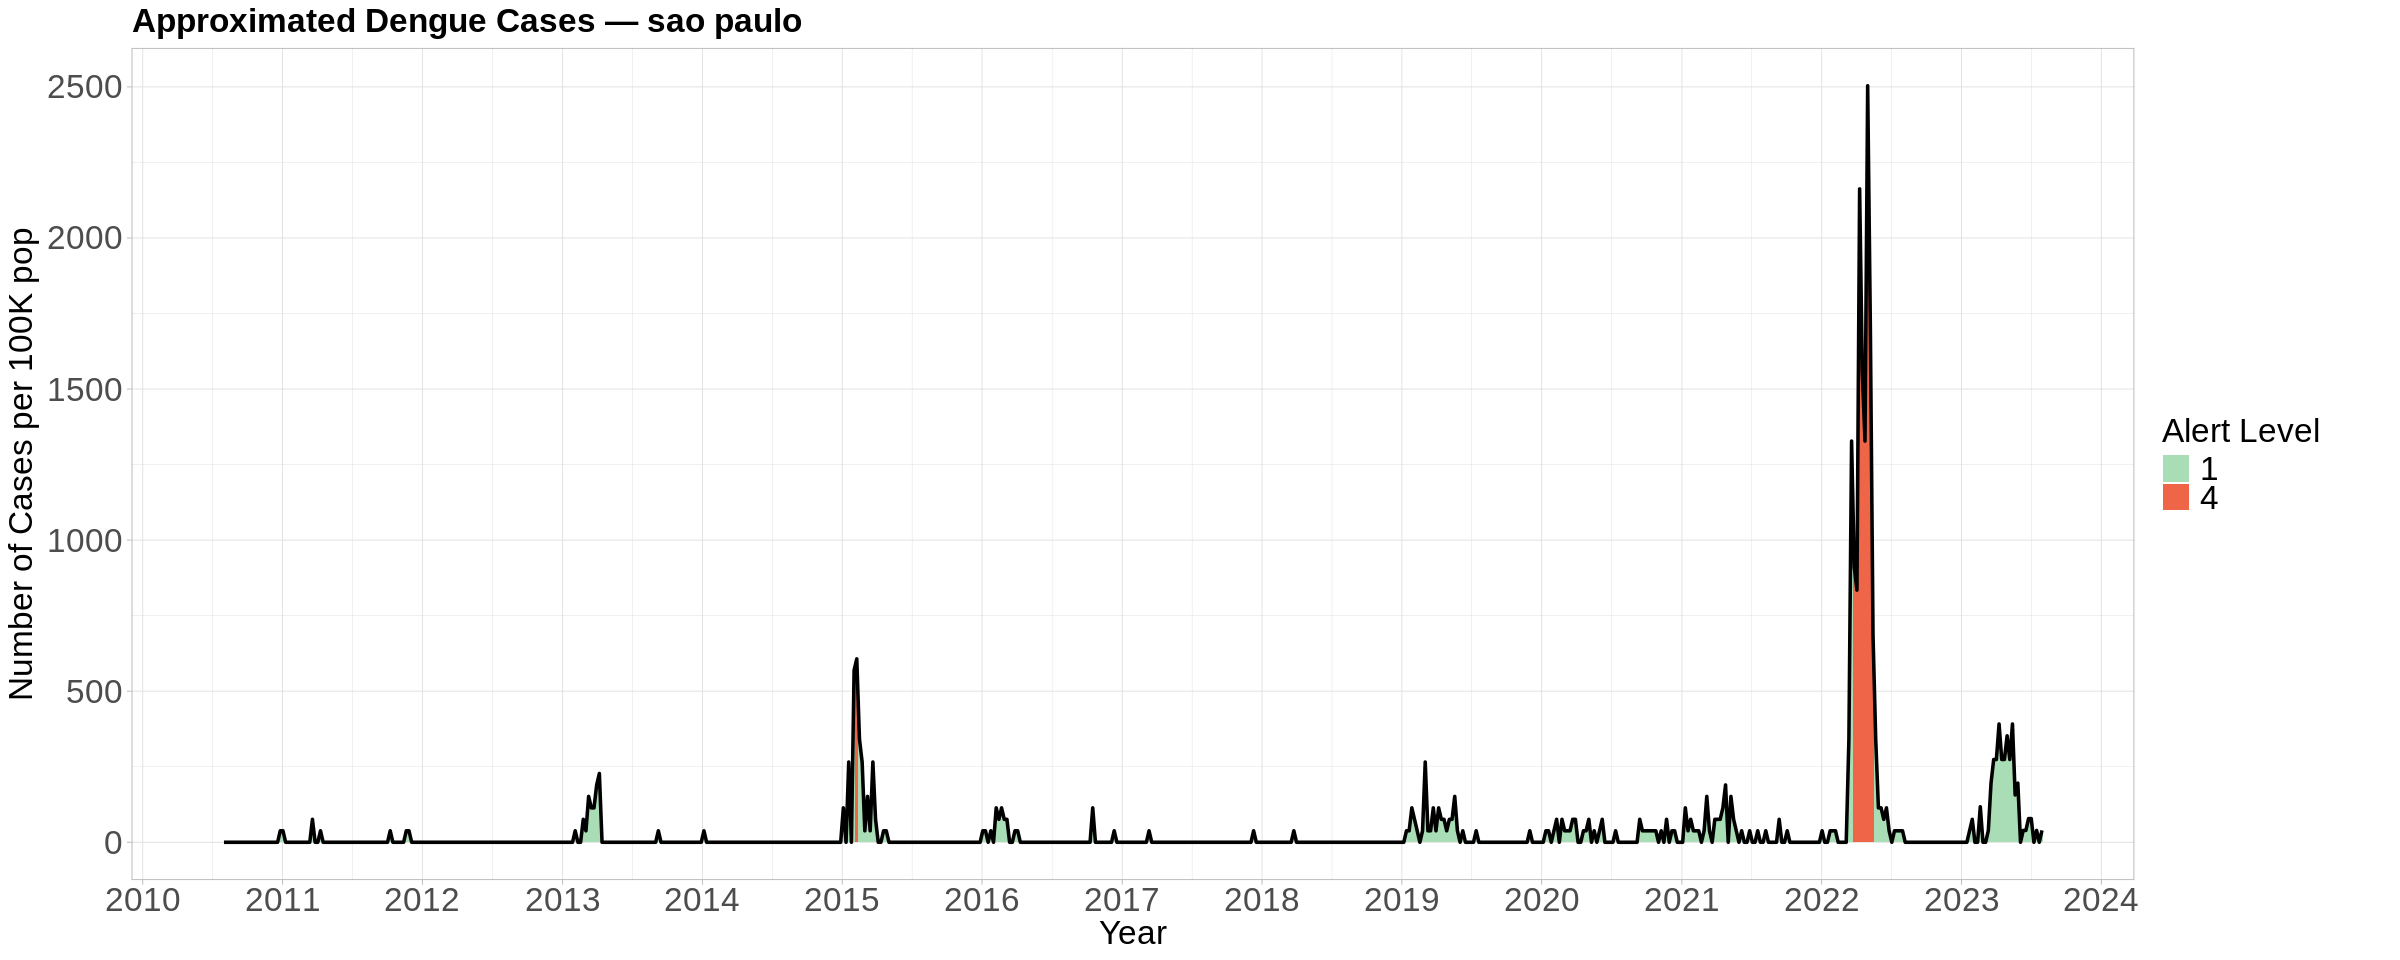

In [ ]:
sp_city_data1 <- sp_data %>% filter(ibge ==  3527900) %>% filter(data_iniSE <= as.Date('2023-08-01') & data_iniSE >= as.Date('2010-08-01'))
plot_data(sp_city_data1, 'sao paulo', 'rate_pop')

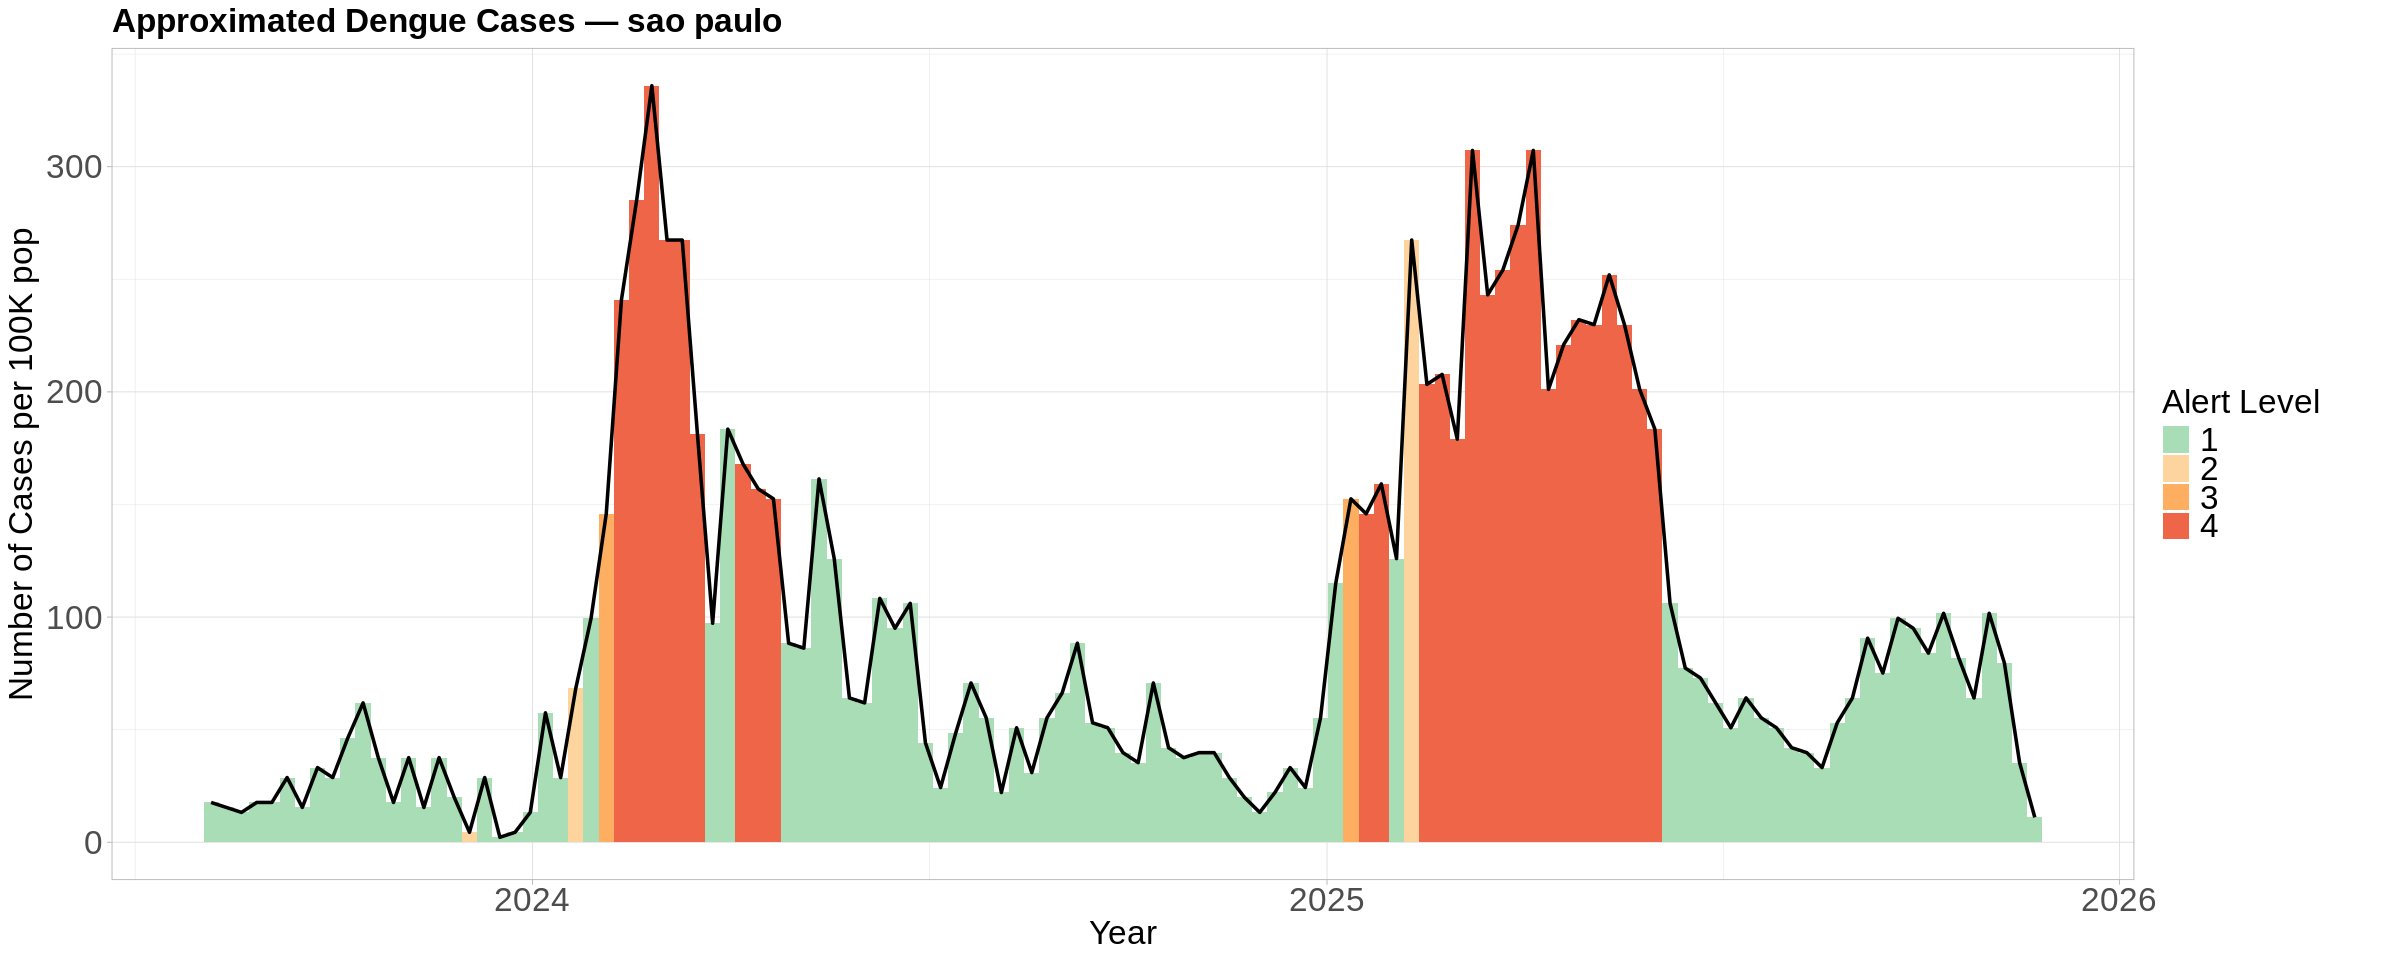

In [ ]:
sp_city_data1 <- sp_data %>% filter(ibge ==  3514403) %>% filter(data_iniSE > as.Date('2023-08-01'))
plot_data(sp_city_data1 , 'sao paulo', 'rate_pop')

In [ ]:
seasoned <- function (inc_data, mon_start, zero_run_weeks = 8L){

# Make seasons, each seasons start is August
inc_data <- inc_data %>%
  mutate(
    week   = isoweek(data_iniSE),
    season = if_else(month(data_iniSE) >= mon_start, year(data_iniSE) + 1L, year(data_iniSE))
  )

# Make index of the season
inc_data <- inc_data %>%
  filter(season != 2010) %>%
  mutate(
    season_start = make_date(season - 1L, mon_start, 1),
    t_in_season  = as.integer((as.Date(data_iniSE) - season_start) / 7) + 1L
  )

## Make Seasons
full_dates <- tibble(
  data_iniSE = seq(
    floor_date(min(inc_data$data_iniSE), "week", week_start = 7),
    floor_date(max(inc_data$data_iniSE), "week", week_start = 7),
    by = "1 week"
  )
)

# CHeck gaps and fill the NAN
inc_data <- inc_data %>%
  mutate(
    data_iniSE = as.Date(data_iniSE),
    sunday = floor_date(data_iniSE, "week", week_start = 1) + days(6)
  ) %>%
  arrange(data_iniSE) %>%
  group_by(sunday) %>%
  slice_tail(n = 1) %>%
  ungroup() %>%
  mutate(data_iniSE = sunday) %>%
  select(-sunday)

data_ori <- inc_data

inc_data <- full_join(full_dates, inc_data, by = "data_iniSE") %>% arrange(data_iniSE)

inc_data <-  inc_data %>%
  arrange(data_iniSE) %>%
  mutate(rate_pop = na.approx(rate_pop, na.rm = FALSE)) %>%
  fill(ibge, .direction = "down")

# Check long zeroes
 bad_seasons <- inc_data %>%
    mutate(mm = month(data_iniSE)) %>%
    filter(mm >= 1, mm <= 6) %>%
    group_by(season) %>%
    summarise(
      max_zero_run = {
        v <- rate_pop
        z <- is.finite(v) & (v == 0)
        r <- rle(z)
        if (!length(r$lengths)) 0L else max(ifelse(r$values, r$lengths, 0L))
      },
      .groups = "drop"
    ) %>%
    filter(max_zero_run >= zero_run_weeks) %>%
    pull(season)

  if (length(bad_seasons)) {
    inc_data <- inc_data %>% filter(!(season %in% bad_seasons))
  }


sp_wide <- inc_data %>%
  select(season, t_in_season, rate_pop) %>%
  pivot_wider(names_from = season, values_from = rate_pop, names_prefix = "season_") %>%
  # filter(t_in_season <= 52) %>% # Remove week 53
  arrange(t_in_season) %>%
  # select(-t_in_season, -season_2026)
  select(-any_of(c("t_in_season", "season_2026")))


return(list(long = inc_data, wide = sp_wide, ori = data_ori))
}

In [ ]:
# ss_res <- seasoned(sp_data %>% filter(ibge == 3549508), 5)
# wide_df <- ss_res$wide

## Take typical seasons

In [ ]:
typical_seasons <- function (df_data, p_lo, p_hi){

  # Get Peaks
  peaks_df  = df_data %>% summarise(across(everything(), ~ suppressWarnings(max(.x, na.rm = TRUE))))
  peaks = as.numeric(peaks_df[1, ])
  geom_mean = exp(mean(log(peaks)))

  # Compute the quantiles
  peaks_df <- peaks_df/ geom_mean
  lo <- quantile(peaks_df, probs = p_lo, na.rm = TRUE)
  hi <- quantile(peaks_df, probs = p_hi, na.rm = TRUE)

  hi_cols <- peaks_df %>% select(where(~ any(.x >= hi, na.rm = TRUE))) %>% names()
  lo_cols <- peaks_df %>% select(where(~ any(.x <= lo, na.rm = TRUE))) %>% names()

  # cat(" remove the high outlier", hi_cols, "and remove the low outlier", lo_cols,"\n")

  # Remove outliers
  df_data <- df_data %>% select(-all_of(hi_cols), -all_of(lo_cols))

  if (ncol(df_data) < 5) {
    print("Removed too many columns")
    return(NULL)
  }

return (df_data)
}

In [ ]:
# typical_seasons <- function(df_data, p_lo = 0.10, p_hi = 0.90, min_cols = 5) {
#   # peaks per season (column)
#   peaks <- sapply(df_data, function(x) suppressWarnings(max(x, na.rm = TRUE)))

#   print(peaks)
#   # peaks <- lapply(peaks, as.numeric)

#   pos   <- peaks[is.finite(peaks) & peaks > 0]
#   if (!length(pos)) return(df_data[, 0, drop = FALSE])
#   G <- exp(mean(log(pos)))
#   dist <- peaks / G
#   # initial band
#   lo <- as.numeric(quantile(dist, p_lo, na.rm = TRUE))
#   hi <- as.numeric(quantile(dist, p_hi, na.rm = TRUE))
#   keep0 <- names(dist)[dist > lo & dist < hi]

#   if (length(keep0) >= min_cols) {
#     return(df_data[, keep0, drop = FALSE])
#   }

#   # widen halfway toward 0/1 *once*
#   p_lo2 <- p_lo/2
#   p_hi2 <- (p_hi + 1)/2
#   lo2 <- as.numeric(quantile(dist, p_lo2, na.rm = TRUE))
#   hi2 <- as.numeric(quantile(dist, p_hi2, na.rm = TRUE))

#   # candidates just outside the original band but inside the widened band
#   cand_low  <- names(dist)[dist > lo2 & dist <= lo]
#   cand_high <- names(dist)[dist >= hi & dist <  hi2]

#   # rank by closeness to original cutoffs
#   rank_low  <- sort(setNames(lo - dist[cand_low],   cand_low))
#   rank_high <- sort(setNames(dist[cand_high] - hi,  cand_high))

#   # interleave from both sides until min_cols reached
#   add_order <- c(names(rank_low), names(rank_high))[order(c(rank_low, rank_high))]
#   add_needed <- max(0, min_cols - length(keep0))
#   add_back <- head(add_order, add_needed)

#   keep <- unique(c(keep0, add_back))
#   df_data[, keep, drop = FALSE]
# }


In [ ]:
run_mem <- function(train_df){

fit <- memmodel(train_df, i.seasons = ncol(train_df), i.method=4)
thr <- fit$pre.post.intervals

return (thr)
}

In [ ]:
# check_consec <- function(x, thr_start, min_run = 3L) {
#   outbreak <- (x >= thr_start)
#   r <- rle(outbreak)
#   r$values[r$values & r$lengths < min_run] <- FALSE
#   inverse.rle(r)
# }

In [ ]:
consec_check <- function(states, min_run = 3L, bridge = 0L) {
  s <- as.character(states)
  b <- s == "outbreak"   # logical vector (raw outbreaks)

  ## 1) enforce min_run on the ORIGINAL runs
  r1 <- rle(b)
  short_true <- r1$values & r1$lengths < min_run
  if (any(short_true)) r1$values[short_true] <- FALSE
  b1 <- inverse.rle(r1)

  ## 2) optionally bridge short endemic gaps BETWEEN surviving outbreaks
  if (bridge > 0L) {
    r2 <- rle(b1)
    n  <- length(r2$values)
    idx <- which(!r2$values & r2$lengths <= bridge)
    # only endemic gaps strictly between two outbreak runs
    idx <- idx[idx > 1 & idx < n & r2$values[idx - 1] & r2$values[idx + 1]]

    if (length(idx)) {
      r2$values[idx] <- TRUE
      b1 <- inverse.rle(r2)
    }
  }

  ifelse(b1, "outbreak", "endemic")
}


In [ ]:
x2 <- c("outbreak", "outbreak", "outbreak", "outbreak","endemic","endemic","outbreak","outbreak","outbreak","outbreak","endemic", "endemic", "outbreak", "endemic", "outbreak")
consec_check(x2, min_run = 4, bridge = 2)

[1] "outbreak" "outbreak" "outbreak" "outbreak" "outbreak" "outbreak"
 [7] "outbreak" "outbreak" "outbreak" "outbreak" "endemic"  "endemic" 
[13] "endemic"  "endemic"  "endemic"

In [ ]:
mem_label <- function(x, thr_pre, thr_post) {

  state <- "endemic"
  out   <- character(length(x))

  for (i in seq_along(x)) {
    val <- x[i]

    if (state == "endemic") {
      if (val >= thr_pre) {
        state <- "outbreak"
      }
    } else if (state == "outbreak") {
      if (val < thr_post) {
        state <- "endemic"
      }
    }

    out[i] <- state
  }

  return (consec_check(out, min_run = 3, bridge = 2))

}


In [ ]:
preprocess <- function(df_data, mon_start = 8L, p_lo = 0.1, p_hi = 0.85) {

  ibges <- unique(df_data$ibge)

  thr_df     <- tibble()
  wide_all   <- vector("list", length(ibges))
  long_all   <- vector("list", length(ibges))
  mem_labs   <- vector("list", length(ibges))
  skipped  <- character(0)

  names(wide_all) <- names(long_all) <- names(mem_labs) <- as.character(ibges)
  i = 0

  for (ib in ibges) {
    i = i+1
    cat("run", ib, "\n")

    df_ib <- df_data %>% filter(ibge == ib)

    # seasonize
    ss_res  <- seasoned(df_ib, mon_start)
    wide_df <- ss_res$wide
    long_df <- if (!is.null(ss_res$long)) ss_res$long else ss_res$indexed

    ori_df <- ss_res$ori

    wide_all[[as.character(ib)]] <- wide_df

    # pick typical seasons
    # wide_df <- wide_df %>% select(-season_2024, -season_2025) #just to be sure, remove the 2024 and 2025
    train_wide <- typical_seasons(wide_df, p_lo = p_lo, p_hi = p_hi)
    if (is.null(train_wide)) {
      skipped <- c(skipped, as.character(ib))
      next
    }

    # run MEM
    mem_res <- run_mem(train_wide)

    # thresholds extraction
    thr_pre  <- as.numeric(mem_res[[5]])
    thr_post <- as.numeric(mem_res[[6]])

    # append thresholds as rows
    thr_df <- bind_rows(thr_df, tibble(ibge = ib, pre = thr_pre, post = thr_post))

    # label based on threshold
    long_2 <- ori_df %>% arrange(data_iniSE) %>% mutate(mem_status = mem_label(rate_pop, thr_pre, thr_post))
    long_all[[as.character(ib)]] <- long_2
    cat('Total municipality processed', i)
    }

  return(list(thr_df = thr_df, res = long_all, train_wide = wide_all, skipped = skipped))
}


In [ ]:
# cc = codes[1:10]
# cc = c(3549508)

In [ ]:
# res_all <- preprocess(sp_data %>% filter(ibge %in% cc))
res_all <- preprocess(sp_data)

run 3538709 
Total municipality processed 1run 3554805 
Total municipality processed 2run 3549904 
Total municipality processed 3run 3554102 
Total municipality processed 4run 3514403 
Total municipality processed 5run 3513801 
Total municipality processed 6run 3547601 
Total municipality processed 7run 3550704 
Total municipality processed 8run 3531605 
Total municipality processed 9run 3510609 
Total municipality processed 10run 3517505 
Total municipality processed 11run 3508108 
Total municipality processed 12run 3502804 
Total municipality processed 13run 3501103 
Total municipality processed 14run 3516606 
Total municipality processed 15run 3506508 
Total municipality processed 16run 3540606 
Total municipality processed 17run 3543907 
Total municipality processed 18run 3506003 
Total municipality processed 19run 3509502 
Total municipality processed 20run 3516705 
Total municipality processed 21run 3522307 
Total municipality processed 22run 3529005 
Total municipality processed

In [ ]:
res_all$skipped

[1] "3512704" "3533700" "3532306" "3512605" "3549508" "3543600" "3515657"
[8] "3527900"

In [ ]:
lal = res_all$res

mem_all <- lal %>%
  discard(is.null) %>%
  bind_rows() %>%
  arrange(ibge, data_iniSE)

In [ ]:
# 1) Clean data: keep data_iniSE as Date
mem_all_clean <- mem_all %>%
  mutate(
    ibge      = as.factor(ibge),
    data_iniSE = as.Date(data_iniSE)
  ) %>%
  arrange(ibge, data_iniSE)

ibges <- sort(unique(mem_all_clean$ibge))

# ---- NEW: precompute monthly tick positions ----
date_range  <- range(mem_all_clean$data_iniSE, na.rm = TRUE)
month_vals  <- seq(
  from = as.Date(format(date_range[1], "%Y-%m-01")),
  to   = as.Date(format(date_range[2], "%Y-%m-01")),
  by   = "6 month"
)
month_text  <- format(month_vals, "%Y-%m")  # labels like 2015-03
# ------------------------------------------------

# 2) Build plot: one trace per ibge, only first is visible
p <- plot_ly()

for (i in seq_along(ibges)) {
  df_i <- mem_all_clean %>% filter(ibge == ibges[i])

  col_vec <- ifelse(df_i$mem_status %in% c("epi", "outbreak"),
                    "red", "green")

  p <- add_bars(
    p,
    data    = df_i,
    x       = ~data_iniSE,
    y       = ~rate_pop,
    name    = as.character(ibges[i]),
    visible = if (i == 1) TRUE else FALSE,
    marker  = list(color = col_vec)
  )
}

# 3) Dropdown buttons: each button turns on exactly one trace
buttons <- lapply(seq_along(ibges), function(i) {
  list(
    method = "update",
    args = list(
      list(visible = seq_along(ibges) == i),
      list(title   = paste("Dengue Rate - IBGE", ibges[i]))
    ),
    label = as.character(ibges[i])
  )
})

p <- layout(
  p,
  title = paste("Dengue Rate - IBGE", ibges[1]),
  xaxis = list(
    title        = "Epidemic week",
    type         = "date",
    tickvals     = month_vals,   # monthly ticks we computed before
    ticktext     = month_text,
    tickangle    = -45,
    showgrid     = TRUE,         # <-- show vertical grid lines
    gridcolor    = "rgba(0,0,0,0.15)",  # light grey
    gridwidth    = 1,
    zeroline     = FALSE
  ),
  yaxis = list(
    title     = "Rate per 100k pop",
    showgrid  = TRUE,
    gridcolor = "rgba(0,0,0,0.1)",
    zeroline  = FALSE
  ),
  updatemenus = list(
    list(
      type       = "dropdown",
      direction  = "down",
      x          = 0.02,
      xanchor    = "left",
      y          = 1.15,
      yanchor    = "top",
      active     = 0,
      buttons    = buttons,
      showactive = TRUE
    )
  )
)

# 4) Save to HTML
saveWidget(p, "mem_ibge_dropdown.html", selfcontained = TRUE)


In [ ]:
# ---- 1) Filter from 2022-01-01 onward and clean data ----
mem_2022 <- mem_all %>%
  mutate(
    ibge      = as.factor(ibge),
    data_iniSE = as.Date(data_iniSE)
  ) %>%
  filter(data_iniSE >= as.Date("2022-01-01")) %>%   # <-- only 2022+
  arrange(ibge, data_iniSE)

ibges <- sort(unique(mem_2022$ibge))

# ---- 2) Precompute tick positions (every 6 months) ----
date_range  <- range(mem_2022$data_iniSE, na.rm = TRUE)
month_vals  <- seq(
  from = as.Date("2022-01-01"),                     # start at 2022-01-01
  to   = as.Date(format(date_range[2], "%Y-%m-01")),
  by   = "6 months"
)
month_text  <- format(month_vals, "%Y-%m")

# ---- 3) Build plot: one trace per ibge, only first visible ----
p <- plot_ly()

for (i in seq_along(ibges)) {
  df_i <- mem_2022 %>% filter(ibge == ibges[i])

  col_vec <- ifelse(df_i$mem_status %in% c("epi", "outbreak"),
                    "red", "green")

  p <- add_bars(
    p,
    data    = df_i,
    x       = ~data_iniSE,
    y       = ~rate_pop,
    name    = as.character(ibges[i]),
    visible = if (i == 1) TRUE else FALSE,
    marker  = list(color = col_vec)
  )
}

# ---- 4) Dropdown buttons ----
buttons <- lapply(seq_along(ibges), function(i) {
  list(
    method = "update",
    args = list(
      list(visible = seq_along(ibges) == i),
      list(title   = paste("Dengue Rate (2022 - 2025) - IBGE", ibges[i]))
    ),
    label = as.character(ibges[i])
  )
})

# ---- 5) Layout with grid + restricted x range ----
p <- layout(
  p,
  title = paste("Dengue Rate (>=2022) - IBGE", ibges[1]),
  xaxis = list(
    title        = "Epidemic week",
    type         = "date",
    range        = c(as.Date("2022-01-01"), date_range[2]),
    tickvals     = month_vals,
    ticktext     = month_text,
    tickangle    = -45,
    showgrid     = TRUE,
    gridcolor    = "rgba(0,0,0,0.15)",
    gridwidth    = 1,
    zeroline     = FALSE
  ),
  yaxis = list(
    title     = "Rate per 100k pop",
    showgrid  = TRUE,
    gridcolor = "rgba(0,0,0,0.1)",
    zeroline  = FALSE
  ),
  updatemenus = list(
    list(
      type       = "dropdown",
      direction  = "down",
      x          = 0.02,
      xanchor    = "left",
      y          = 1.15,
      yanchor    = "top",
      active     = 0,
      buttons    = buttons,
      showactive = TRUE
    )
  )
)

# ---- 6) Save HTML ----
saveWidget(p, "mem_ibge_dropdown_2022.html", selfcontained = TRUE)


In [ ]:
# gt = as.character(codes[[9]])
# target_df <- res_all$res[[gt]]
# thr_target <- res_all$thr_df %>% filter(ibge == gt) %>% pull(pre)
# plot_mem_status(target_df %>% filter(data_iniSE >= as.Date('2022-01-01')), thr_target)

ERROR: Error in plot_mem_status(target_df %>% filter(data_iniSE >= as.Date("2022-01-01")), : could not find function "plot_mem_status"


In [ ]:
# p <- plot_mem_status(target_df %>% filter(data_iniSE>'2023-08-01'), thr_target)
# p

In [ ]:
# plot_mem_status(target_df , thr_target)

## Export

In [ ]:
write_csv(mem_all, "MEM_classification_SP.csv")

In [ ]:
drive_upload(
  media = "MEM_classification_SP.csv",
  name  = "MEM_classification_SP.csv",
  path  = as_id("1wgPvGUXoYvL4iD-jZkO4pxrN48dJDSLa"),
  overwrite = TRUE
)

Local file:

• MEM_classification_SP.csv

Uploaded into Drive file:

• MEM_classification_SP.csv <id: 1O8SEgIsM741l6VTNqgEaKjciZug-prZX>

With MIME type:

• text/csv

